# Load Library

In [1]:
# general imports
import sys
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import multiprocessing as mp

In [2]:
torch.__version__

'2.2.1+cu121'

In [3]:
# get the DGD modules (once the current version is public we can switch to the repo)
# git clone https://github.com/Center-for-Health-Data-Science/DeepGenerativeDecoder.git
# for now I added them to this repo, but the imports will stay the same
from base.dgd.nn import NB_Module
from base.dgd.DGD import DGD

# get the new stuff
from base.utils.helpers import set_seed
from base.model.decoder import Decoder
from base.data.combined import GeneExpressionDatasetCombined
from base.engine.train import train_dgd_combined, train_dgd_mirna

# Set seeds, device, and directory

In [4]:
# set random seeds, device and data directory
seed = 42
set_seed(seed)

num_workers = 14

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

datadir = "./data/"

cpu


# Load Data

In [5]:
# tcga_mrna_raw = pd.read_table("data/TCGA_mrna_counts_match_transposed.tsv", sep='\t', index_col=[0])
# tcga_mirna_raw = pd.read_table("data/TCGA_mirna_counts_match_transposed.tsv", sep='\t', index_col=[0])
tcga_mrna_raw = pd.read_table("data/TCGA_mrna_counts_match_iso.tsv", sep='\t', index_col=[0])
tcga_mirna_raw = pd.read_table("data/TCGA_mirna_counts_match_iso.tsv", sep='\t', index_col=[0])

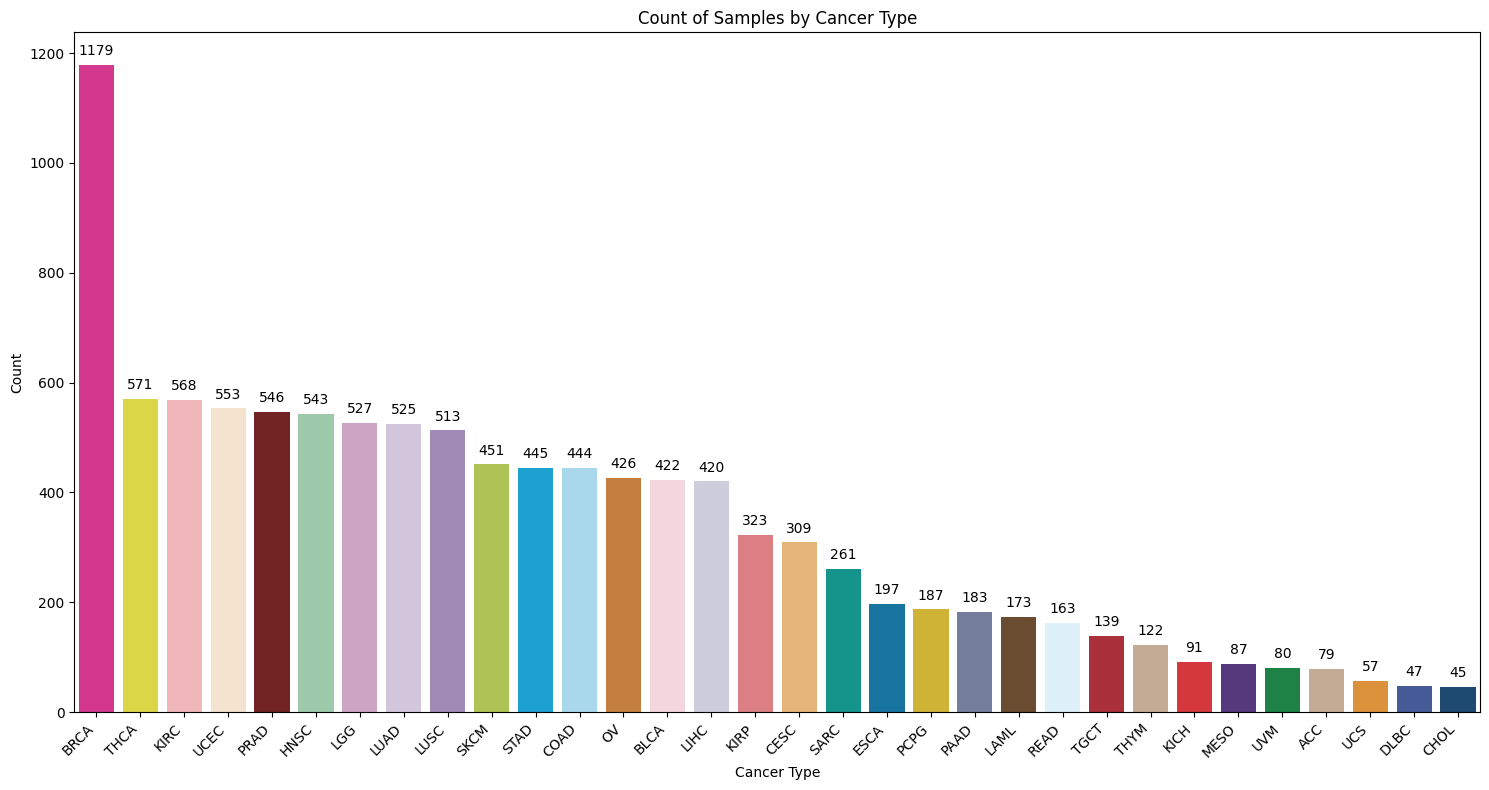

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

color_mapping = dict(zip(tcga_mrna_raw['cancer_type'], tcga_mrna_raw['color']))

primary_site_counts = tcga_mrna_raw['cancer_type'].value_counts().reset_index()
primary_site_counts.columns = ['cancer_type', 'count']

# Create a bar plot
plt.figure(figsize=(15, 8))
barplot = sns.barplot(x='cancer_type', hue='cancer_type', y='count', data=primary_site_counts, palette=color_mapping)
plt.xlabel('Cancer Type')
plt.ylabel('Count')
plt.title('Count of Samples by Cancer Type')
plt.xticks(rotation=45, ha='right')  # Rotate the x labels to show them more clearly

# Annotate each bar with the count
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'),  # Format the count as a string with no decimal places
                     (p.get_x() + p.get_width() / 2., p.get_height()),  # Position the text at the center of the bar
                     ha='center', va='center',  # Center the text horizontally and vertically
                     xytext=(0, 10),  # Offset the text by 10 points vertically
                     textcoords='offset points')  # Use offset points for the text coordinates

plt.tight_layout()  # Adjust the layout to fit the x labels
plt.show()

In [7]:
# make data split for train and validation sets
mrna_out_dim = tcga_mrna_raw.shape[1]-2
mirna_out_dim = tcga_mirna_raw.shape[1]-2

# shuffle the data
tcga_mrna_raw = tcga_mrna_raw.sample(frac=1, random_state=seed)
tcga_mirna_raw = tcga_mirna_raw.sample(frac=1, random_state=seed)

In [8]:
# make data split for train, validation, and test sets
train_ratio, val_ratio, test_ratio = 0.7, 0.15, 0.15

# Calculate split indices
total_samples = len(tcga_mrna_raw)
train_end = int(train_ratio * total_samples)
val_end = train_end + int(val_ratio * total_samples)

# Split the data
train_mrna = tcga_mrna_raw.iloc[:train_end]
val_mrna = tcga_mrna_raw.iloc[train_end:val_end]
test_mrna = tcga_mrna_raw.iloc[val_end:]

train_mirna = tcga_mirna_raw.iloc[:train_end]
val_mirna = tcga_mirna_raw.iloc[train_end:val_end]
test_mirna = tcga_mirna_raw.iloc[val_end:]

# Train, val, and test data loaders
# Default scaling_type = "mean"
train_dataset = GeneExpressionDatasetCombined(train_mrna, train_mirna)
validation_dataset = GeneExpressionDatasetCombined(val_mrna, val_mirna)
test_dataset = GeneExpressionDatasetCombined(test_mrna, test_mirna)

train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=256, 
                                           shuffle=True,
                                           num_workers=num_workers,
                                           pin_memory=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, 
                                                batch_size=256, 
                                                shuffle=True,
                                                num_workers=num_workers,
                                                pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=256, 
                                          shuffle=False,
                                          num_workers=num_workers,
                                          pin_memory=True)

# Define scaling for NB
# Each sample gets a scaling factor
# However, it is not used anywhere in the code
# mrna_scaling_factors = torch.mean(torch.Tensor(train_mrna.iloc[:,:-2].to_numpy()), dim=-1).unsqueeze(1)
# mrna_validation_scaling_factors = torch.mean(torch.Tensor(val_mrna.iloc[:,:-2].to_numpy()), dim=-1).unsqueeze(1)
# mrna_test_scaling_factors = torch.mean(torch.Tensor(test_mrna.iloc[:,:-2].to_numpy()), dim=-1).unsqueeze(1)
# mirna_scaling_factors = torch.mean(torch.Tensor(train_mirna.iloc[:,:-2].to_numpy()), dim=-1).unsqueeze(1)
# mirna_validation_scaling_factors = torch.mean(torch.Tensor(val_mirna.iloc[:,:-2].to_numpy()), dim=-1).unsqueeze(1)
# mirna_test_scaling_factors = torch.mean(torch.Tensor(test_mirna.iloc[:,:-2].to_numpy()), dim=-1).unsqueeze(1)

In [9]:
print(train_dataset.mrna_data.shape)
print(validation_dataset.mrna_data.shape)
print(test_dataset.mrna_data.shape)

print(train_dataset.mirna_data.shape)
print(validation_dataset.mirna_data.shape)
print(test_dataset.mirna_data.shape)

print(mrna_out_dim)
print(mirna_out_dim)

torch.Size([7473, 19784])
torch.Size([1601, 19784])
torch.Size([1602, 19784])
torch.Size([7473, 2450])
torch.Size([1601, 2450])
torch.Size([1602, 2450])
19784
2450


In [10]:
n_tissues = len(np.unique(train_dataset.label))
n_tissues

32

# Model Setup

In [11]:
# hyperparameters
latent_dim = 20
hidden_dims = [128, 256, 512]
reduction_type = "sum" # output loss reduction

In [12]:
# decoder setup

# set up an output module for the mRNA expression data
mrna_out_fc = nn.Sequential(
    nn.Linear(hidden_dims[-1], mrna_out_dim)
    )
output_mrna_layer = NB_Module(mrna_out_fc, mrna_out_dim, scaling_type="mean")
output_mrna_layer.n_features = mrna_out_dim

# set up an output module for the miRNA expression data
mirna_out_fc = nn.Sequential(
    nn.Linear(hidden_dims[-1], mirna_out_dim)
    )
output_mirna_layer = NB_Module(mirna_out_fc, mirna_out_dim, scaling_type="mean")
output_mirna_layer.n_features = mirna_out_dim


# set up the decoder
decoder = Decoder(latent_dim, hidden_dims, [output_mrna_layer, output_mirna_layer]).to(device)

In [13]:
# init a DGD model

gmm_mean_scale = 5.0 # usually between 2 and 10
sd_mean_init = 0.2 * gmm_mean_scale / n_tissues # empirically good for single-cell data at dimensionality 20

dgd = DGD(
        decoder=decoder,
        n_mix=n_tissues,
        rep_dim=latent_dim,
        gmm_spec={"mean_init": (gmm_mean_scale, 5.0), "sd_init": (sd_mean_init, 1.0), "weight_alpha": 1}
)

# Training

  0%|                                                                                                                                                                                                                                                                                    | 0/1001 [00:00<?, ?it/s]

0 7.51895805653984 8.947254188056293


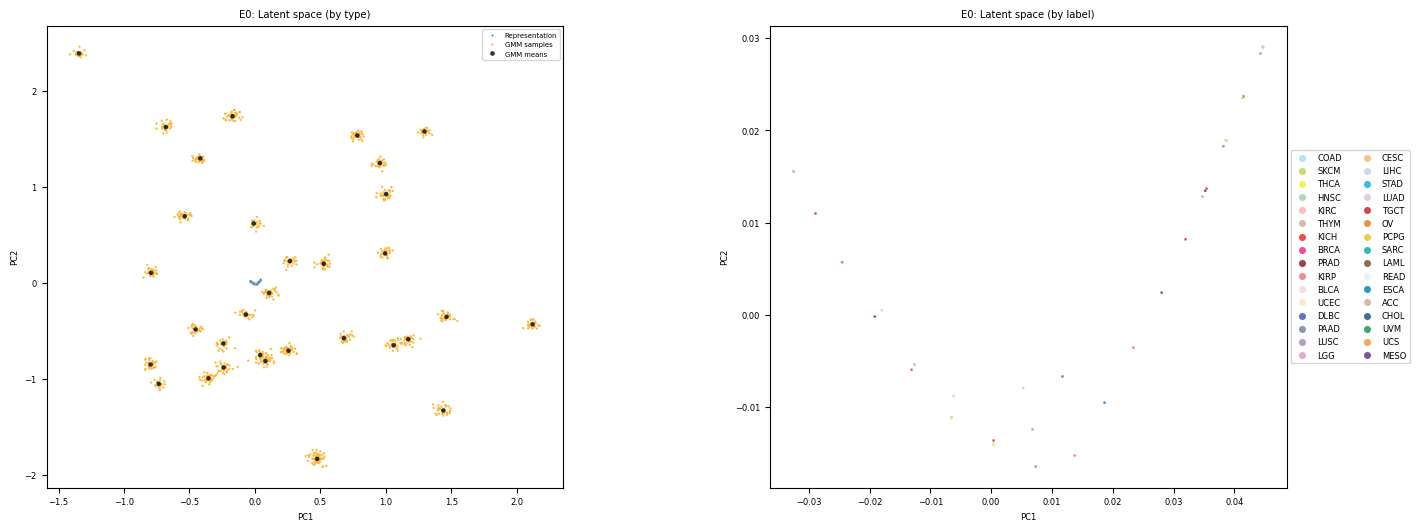

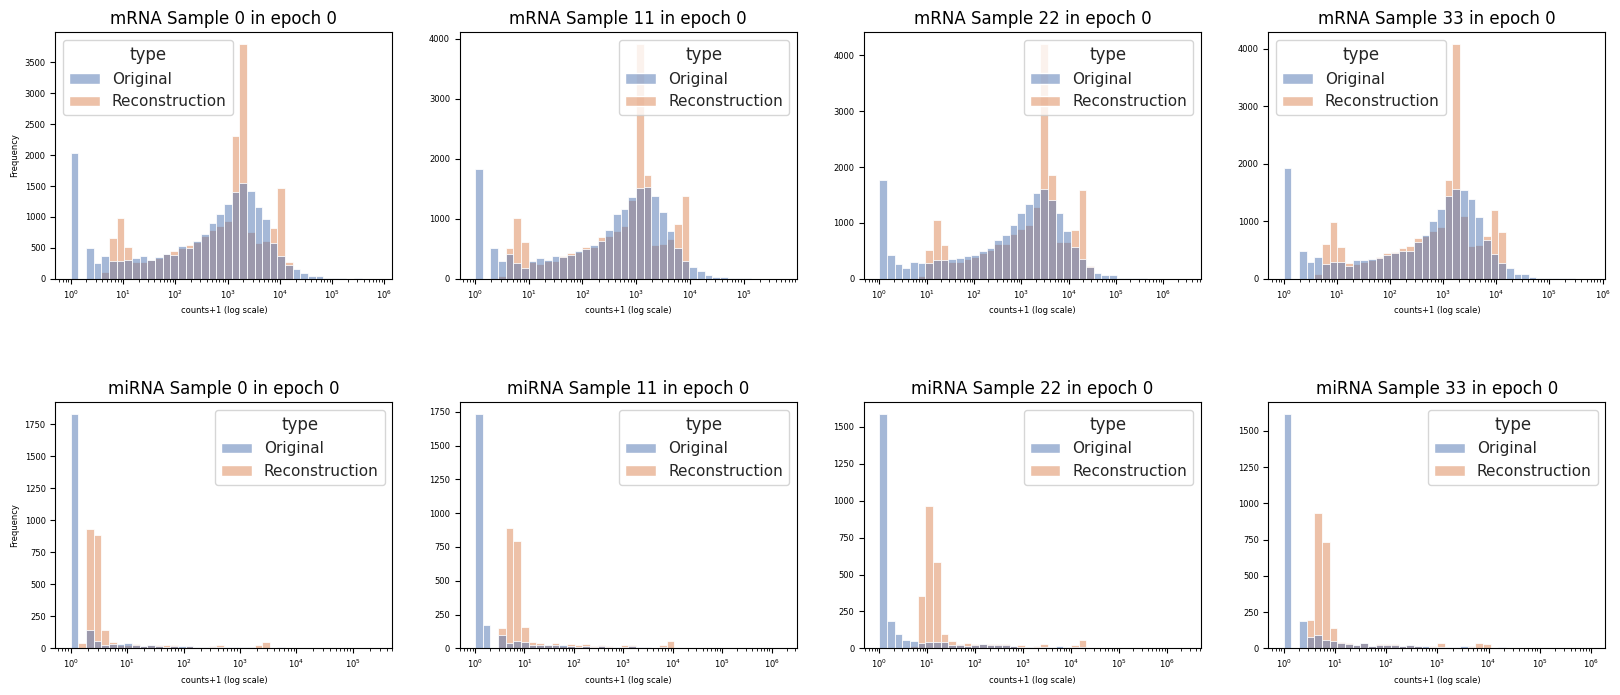

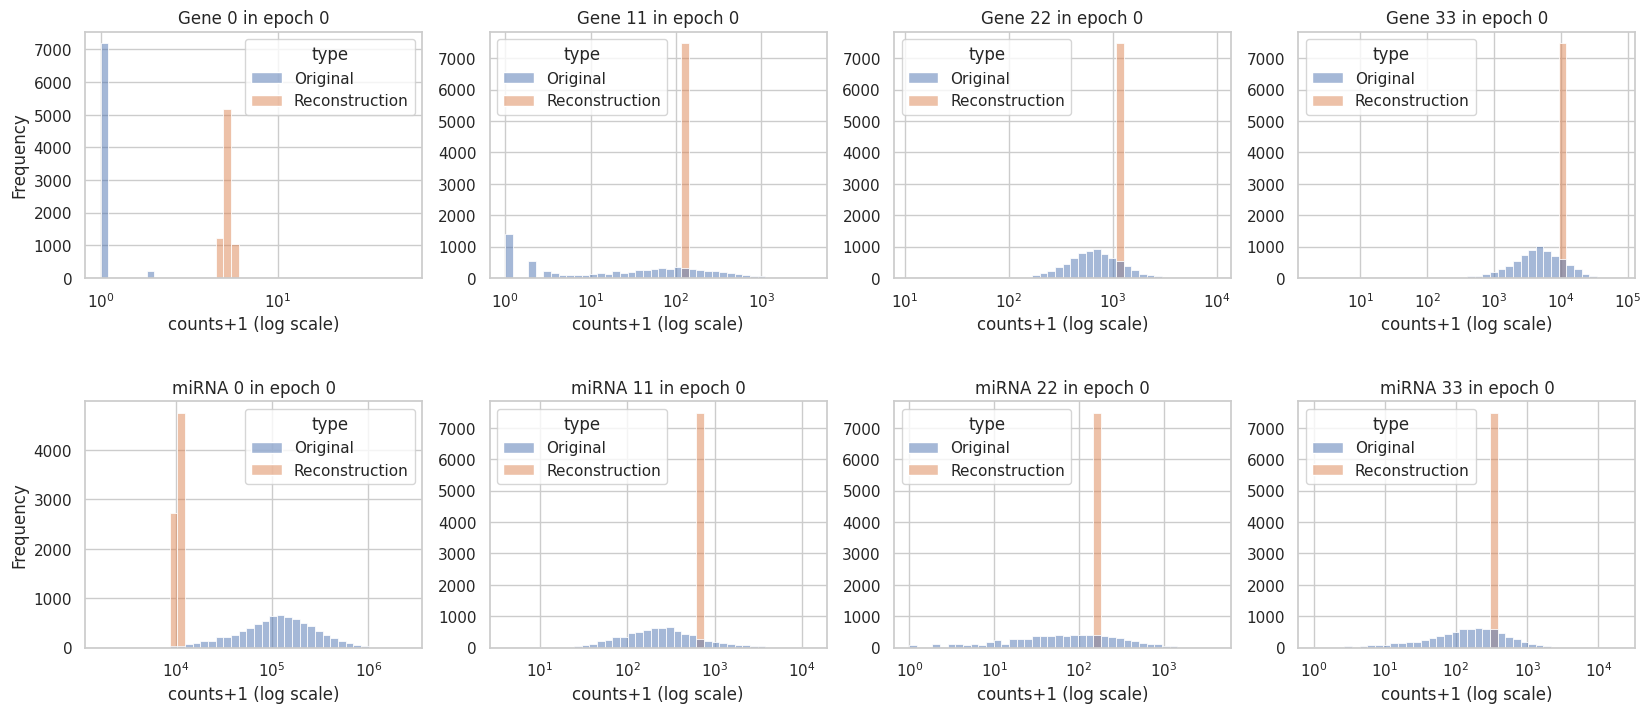

 20%|████████████████████████████████████████████████████▋                                                                                                                                                                                                                   | 200/1001 [23:03<1:54:31,  8.58s/it]

200 5.767540914121263 2.259480951846502


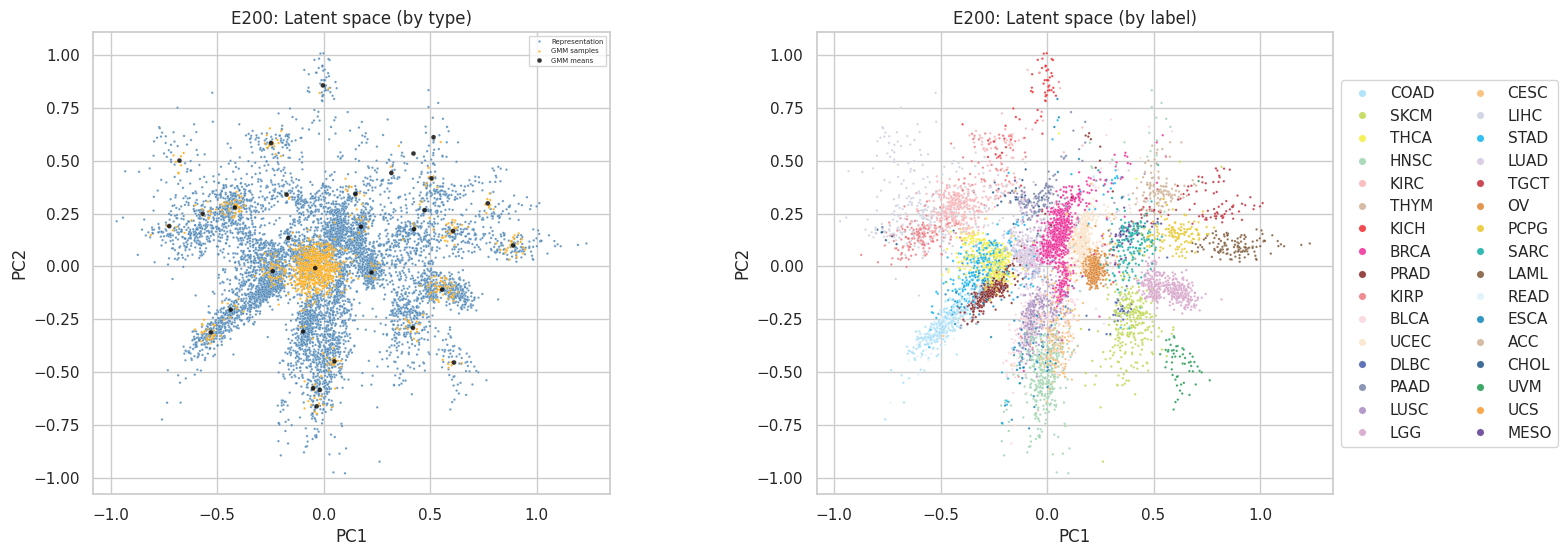

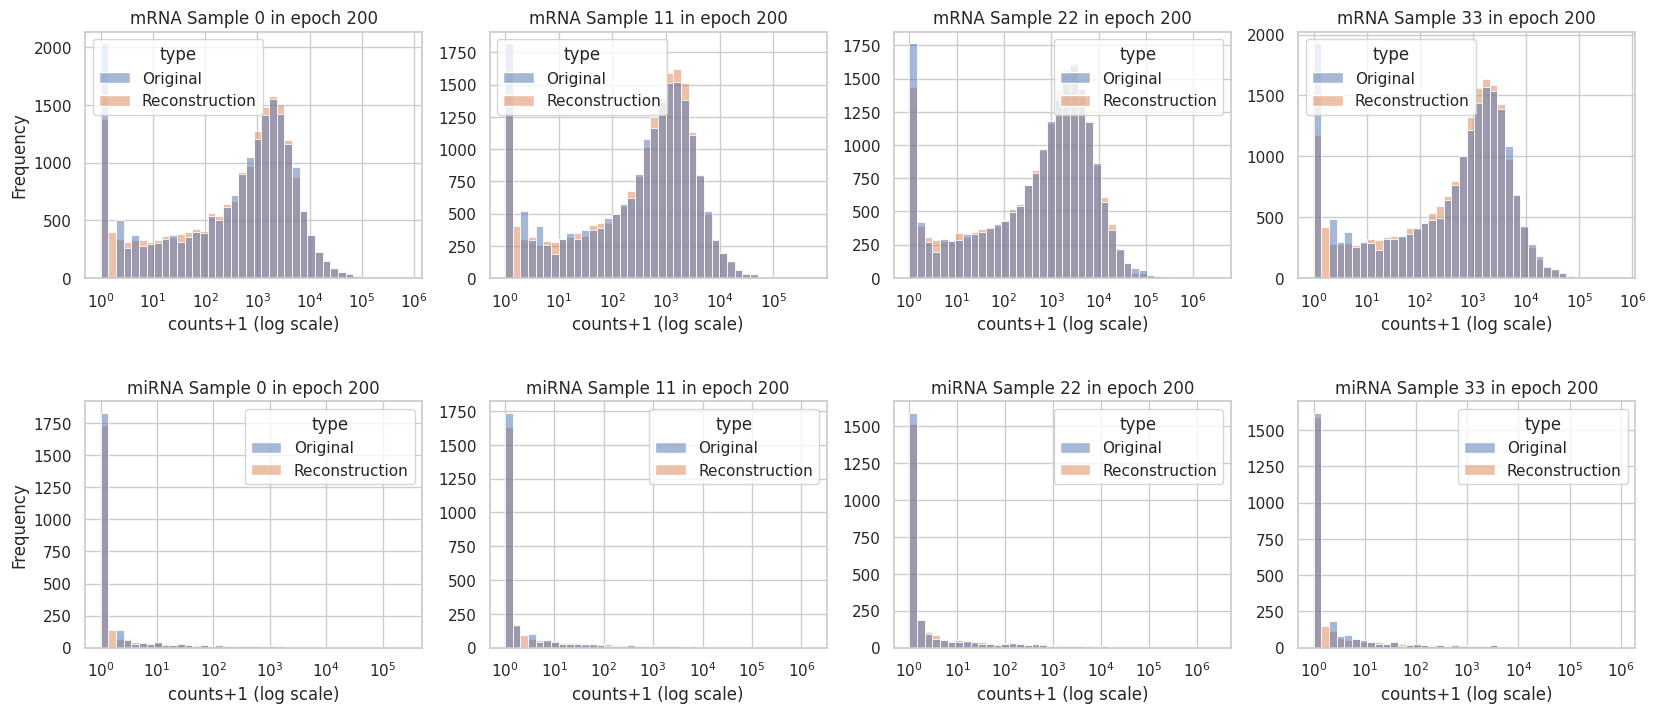

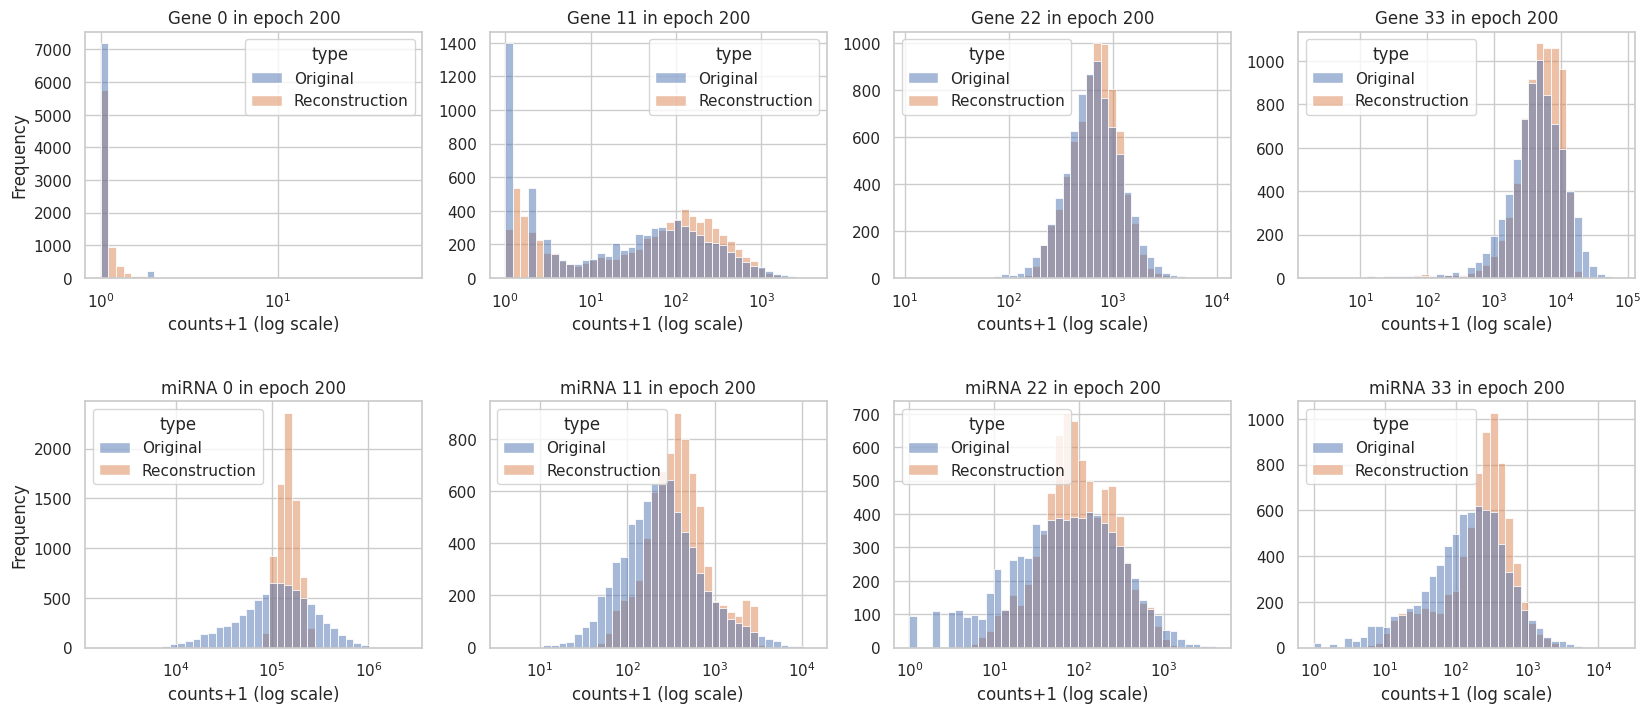

 40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                              | 400/1001 [45:09<1:00:41,  6.06s/it]

400 5.732612752093358 2.264888887804497


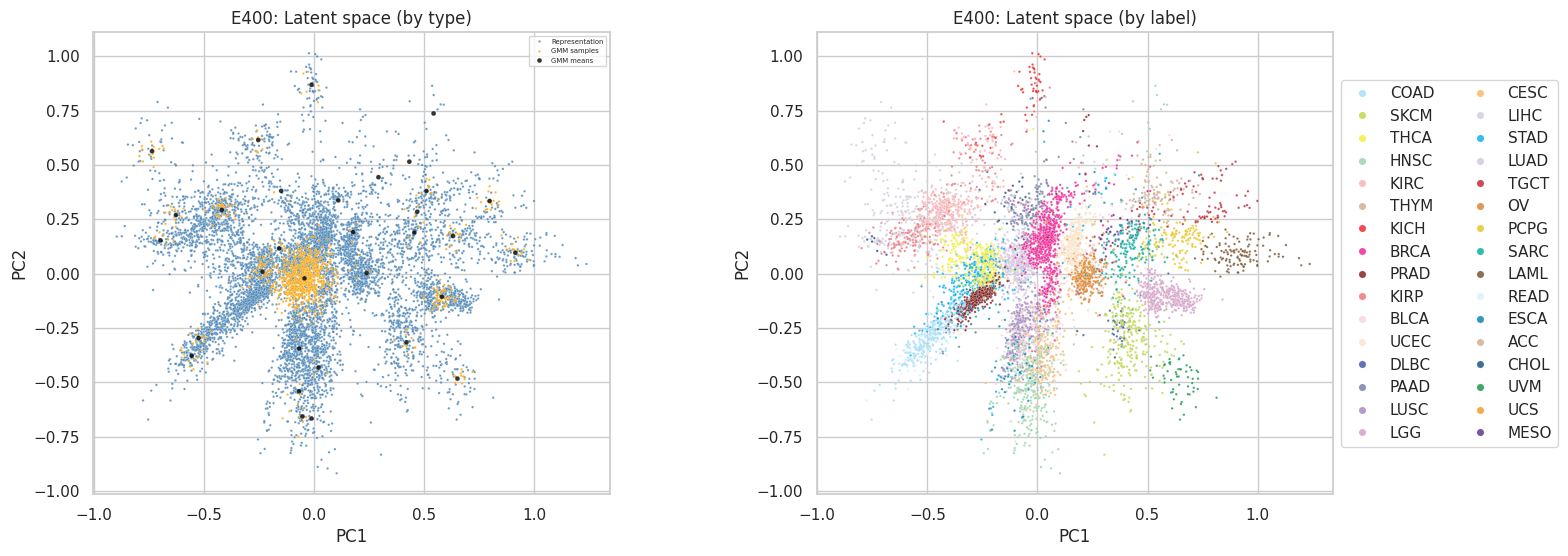

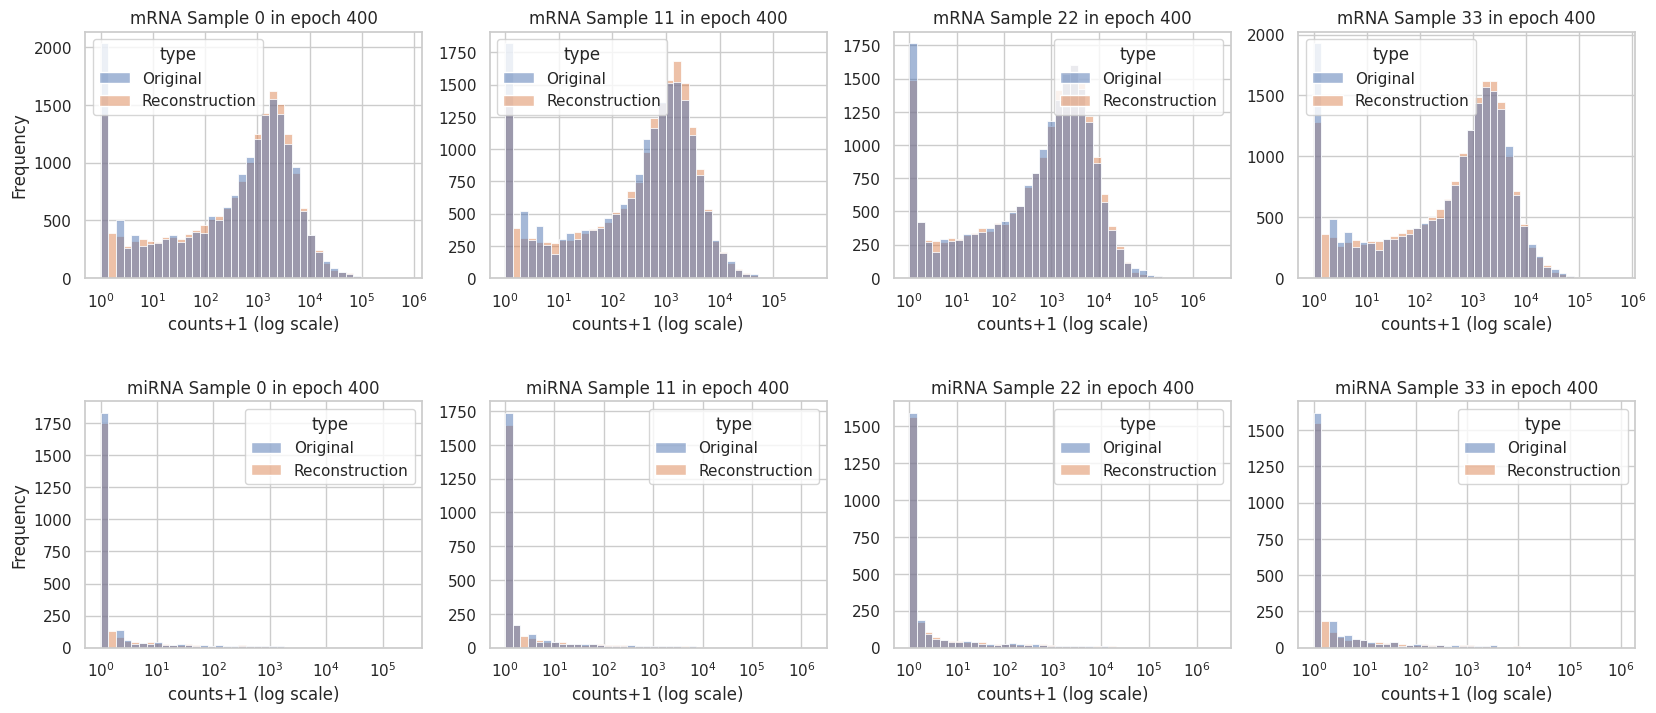

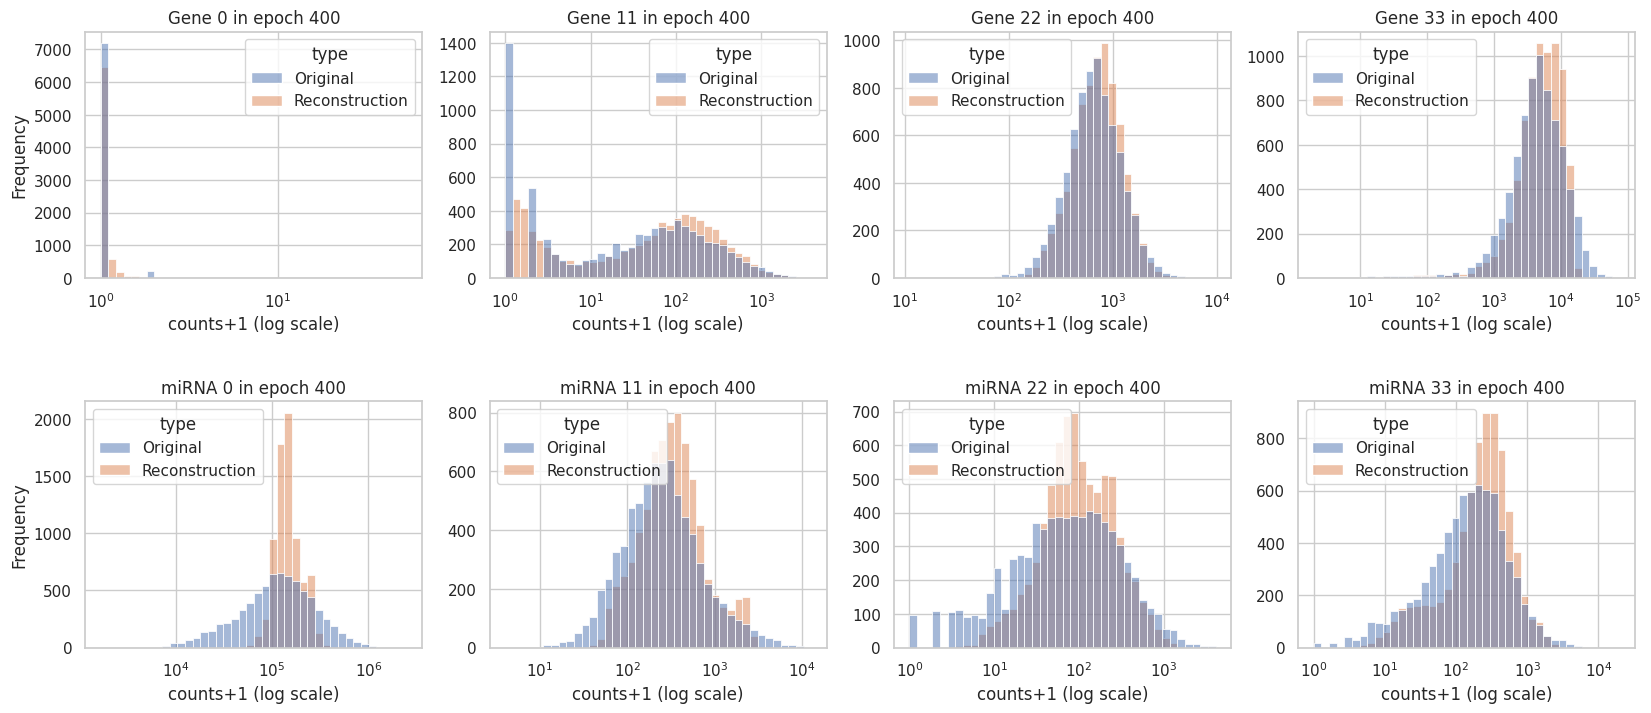

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                         | 600/1001 [1:09:54<38:05,  5.70s/it]

600 5.7301186398691515 2.2650603657138118


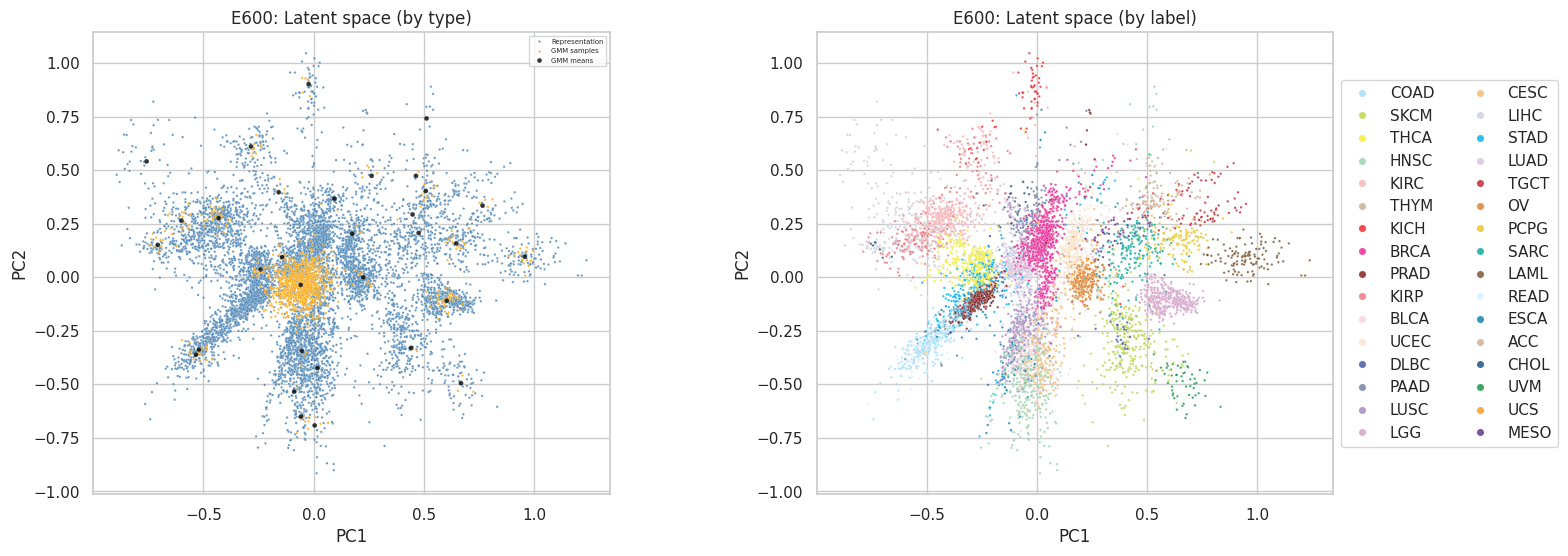

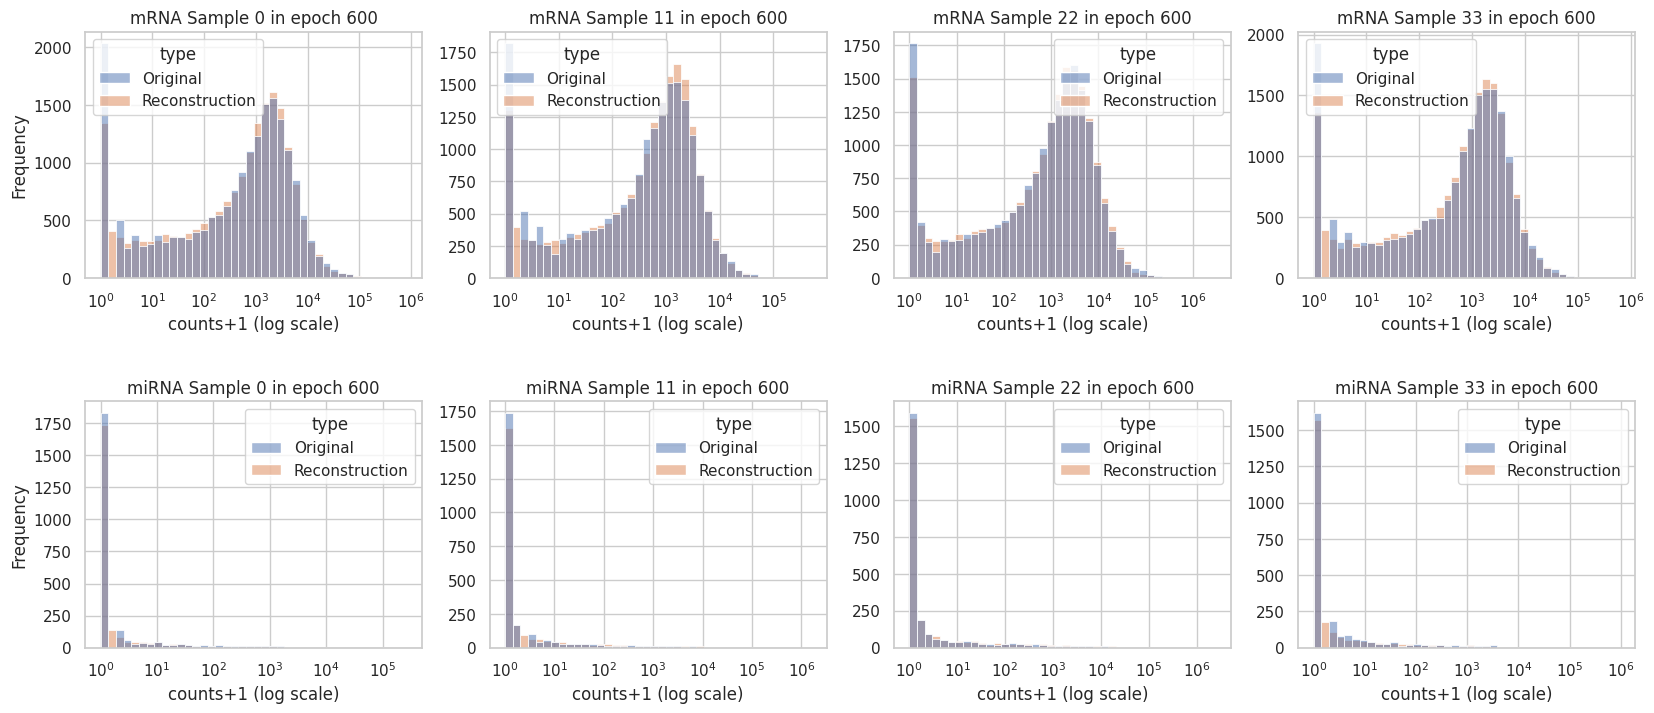

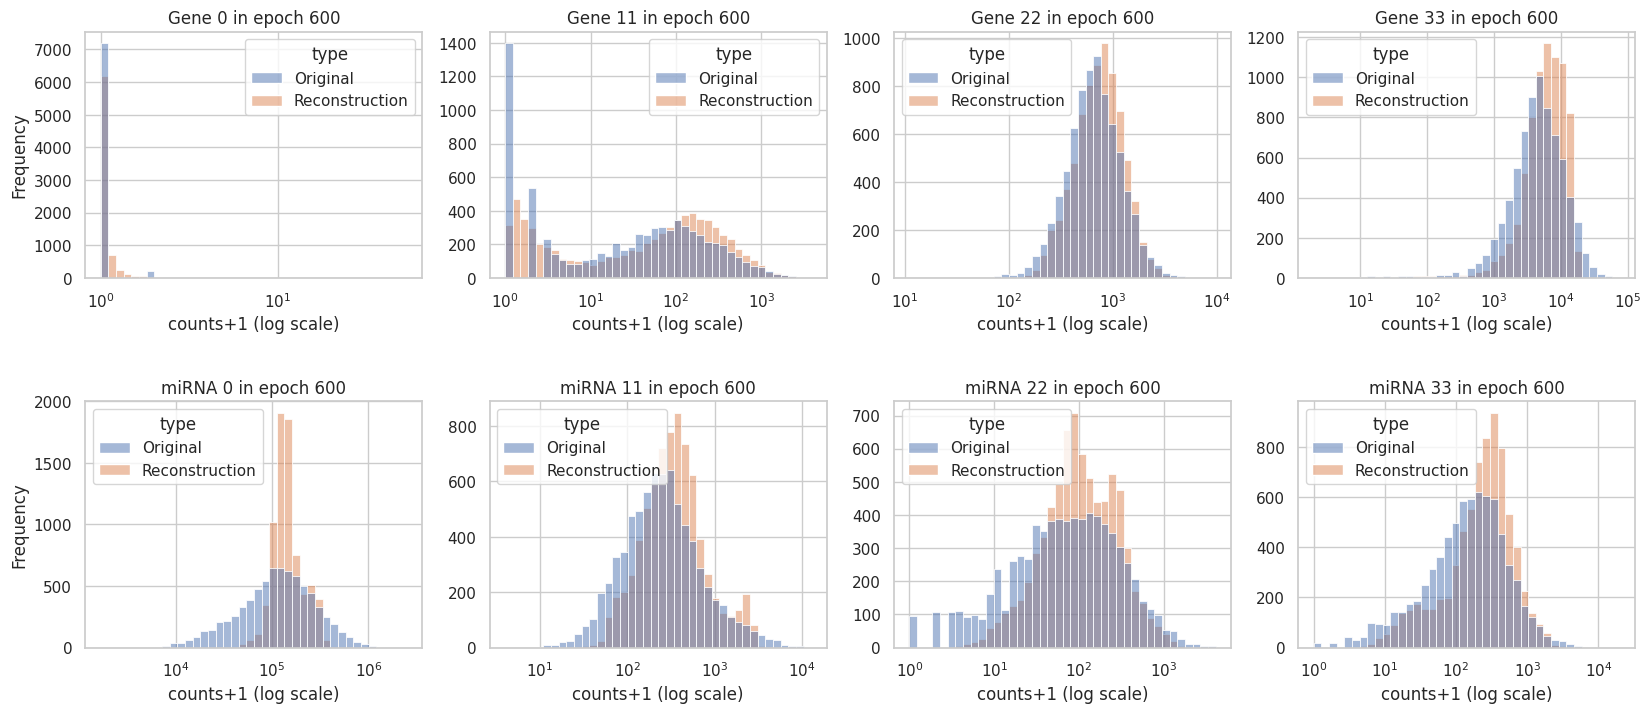

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 800/1001 [1:31:22<27:13,  8.13s/it]

800 5.729408249667651 2.2659751077207604


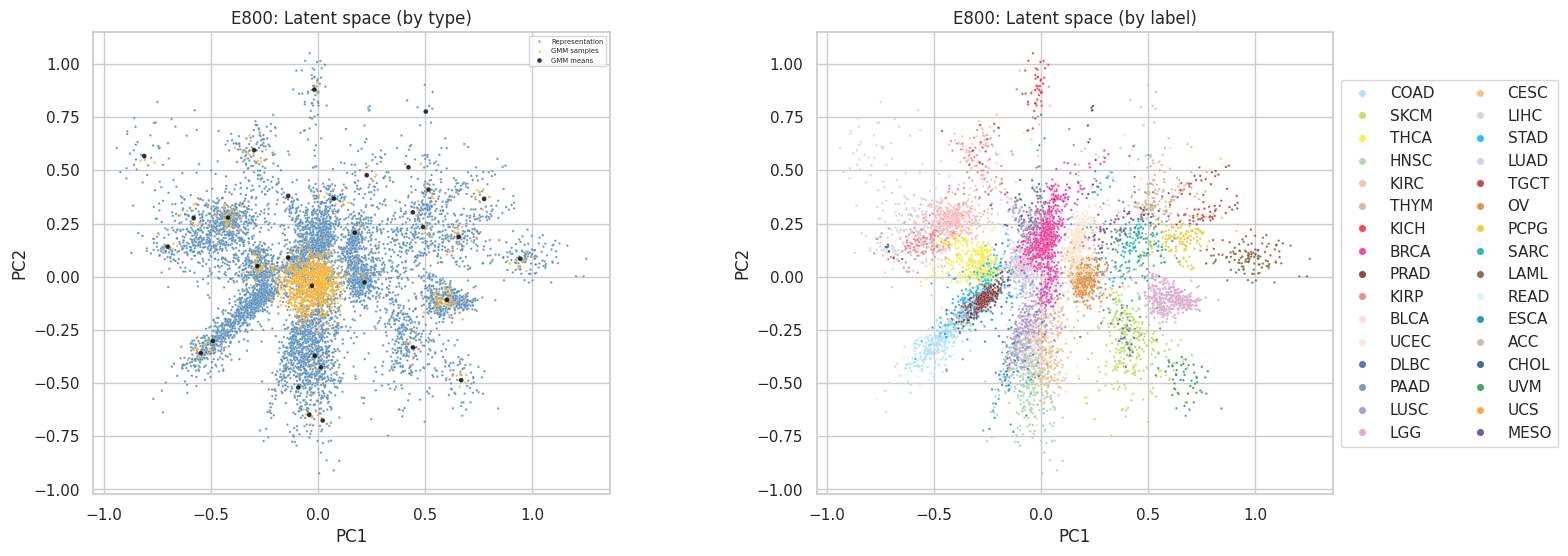

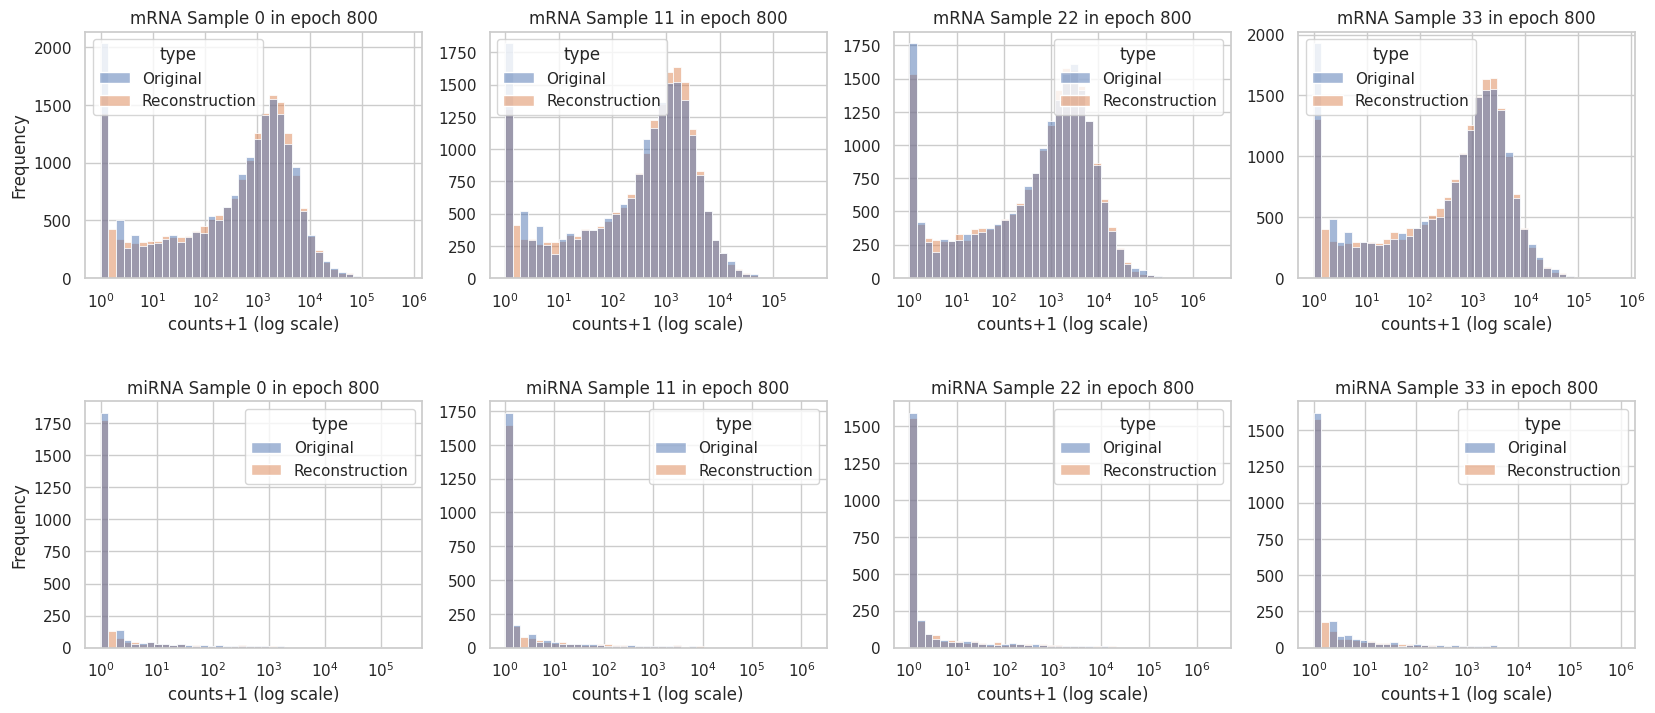

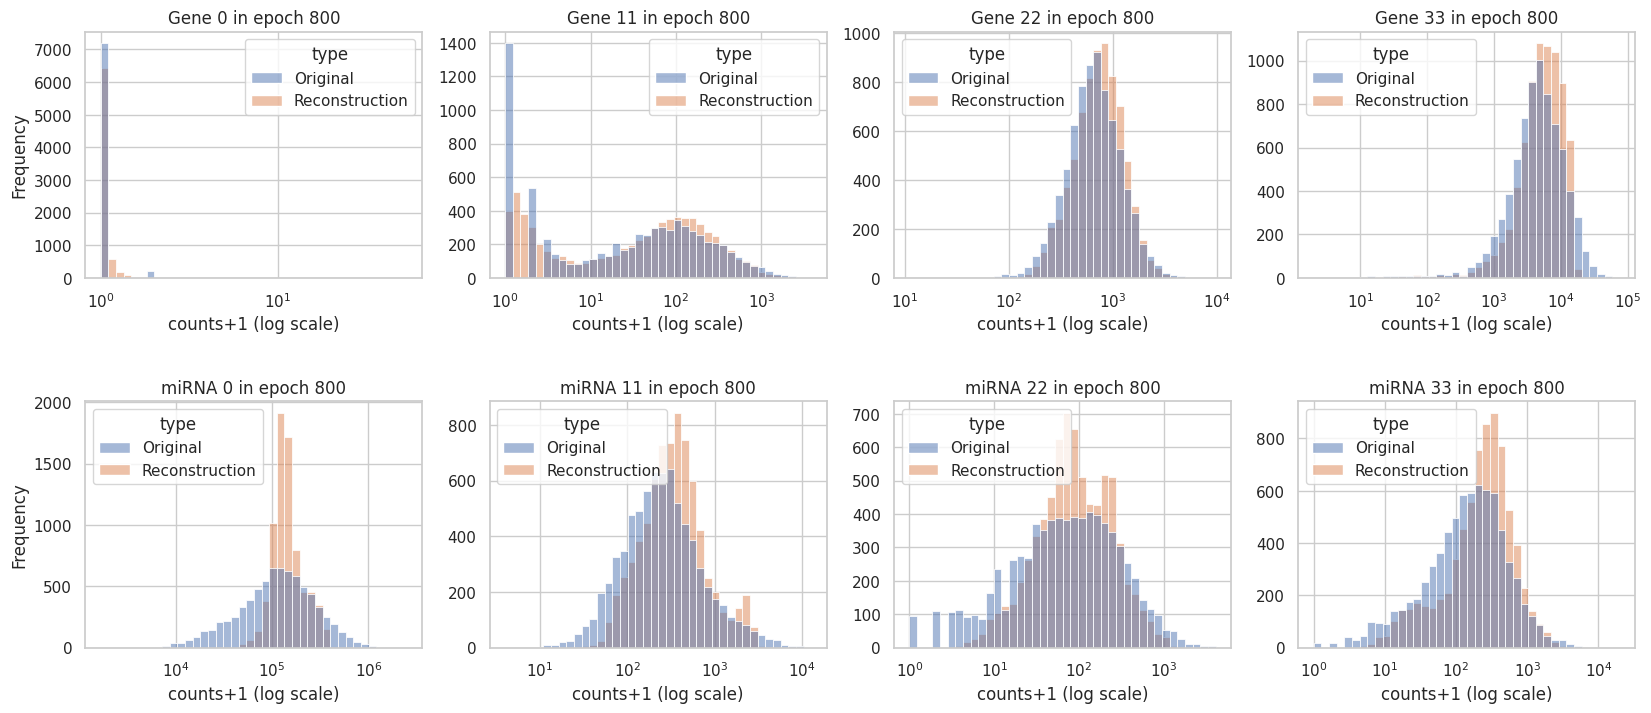

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1000/1001 [1:55:44<00:06,  6.33s/it]

1000 5.729417197142854 2.266972805692731


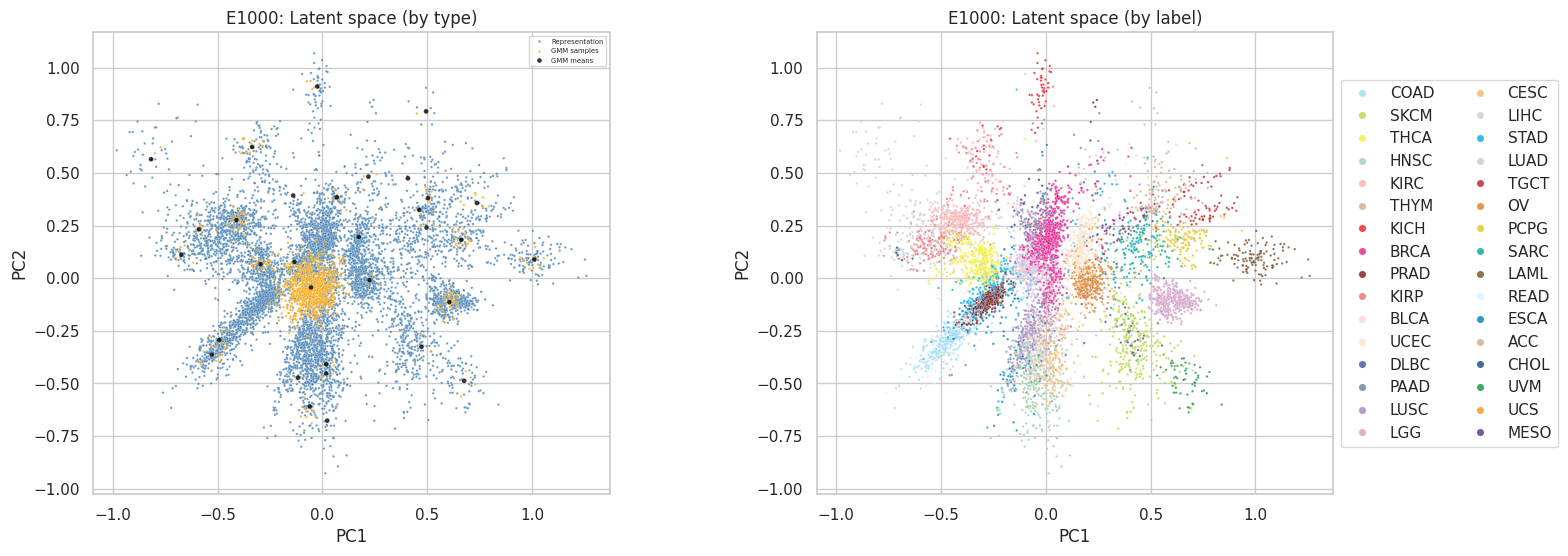

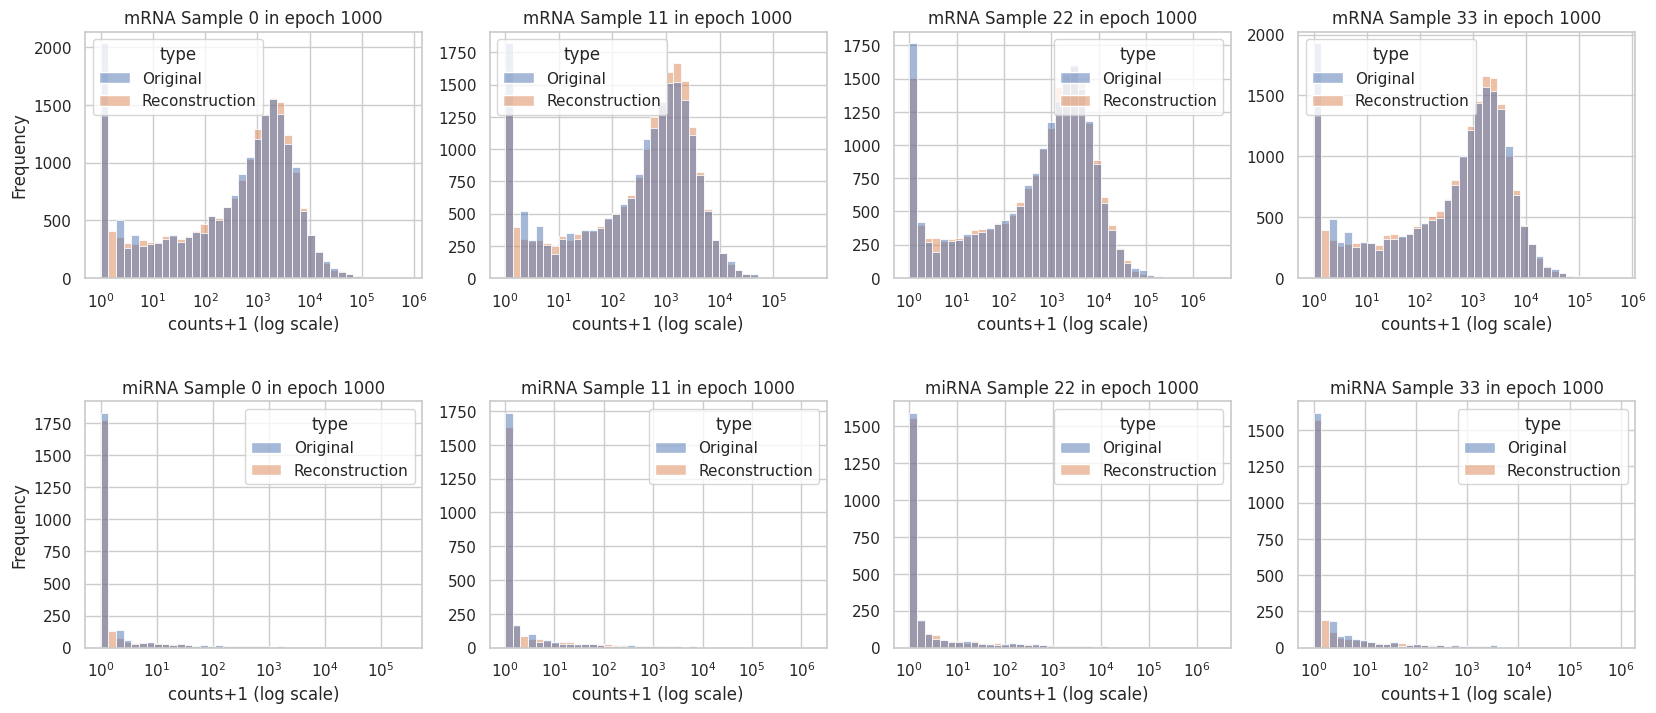

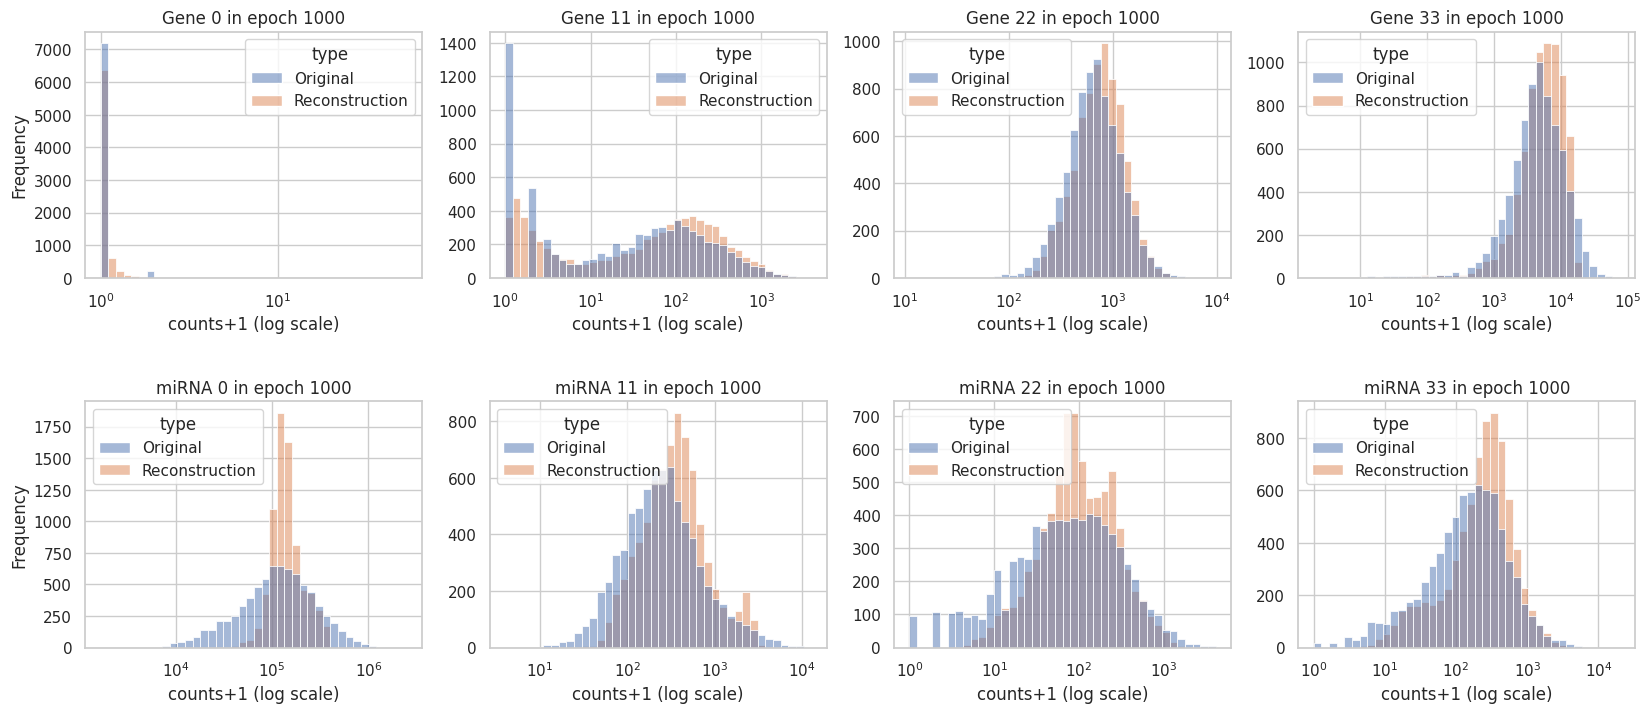

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1001/1001 [1:55:57<00:00,  6.95s/it]


In [14]:
# train for n epochs and plot learning curves

n_epochs = 1001
pr = 200 # how often to print epoch
plot = 200 # how often to print plot

loss_tab = train_dgd_combined(
    dgd, train_loader, validation_loader, device, 
    learning_rates={'dec':0.001,'rep':0.01,'gmm':0.01},
    weight_decay=0.,nepochs=n_epochs,pr=pr,plot=plot,reduction_type=reduction_type
    )

# Plotting Loss

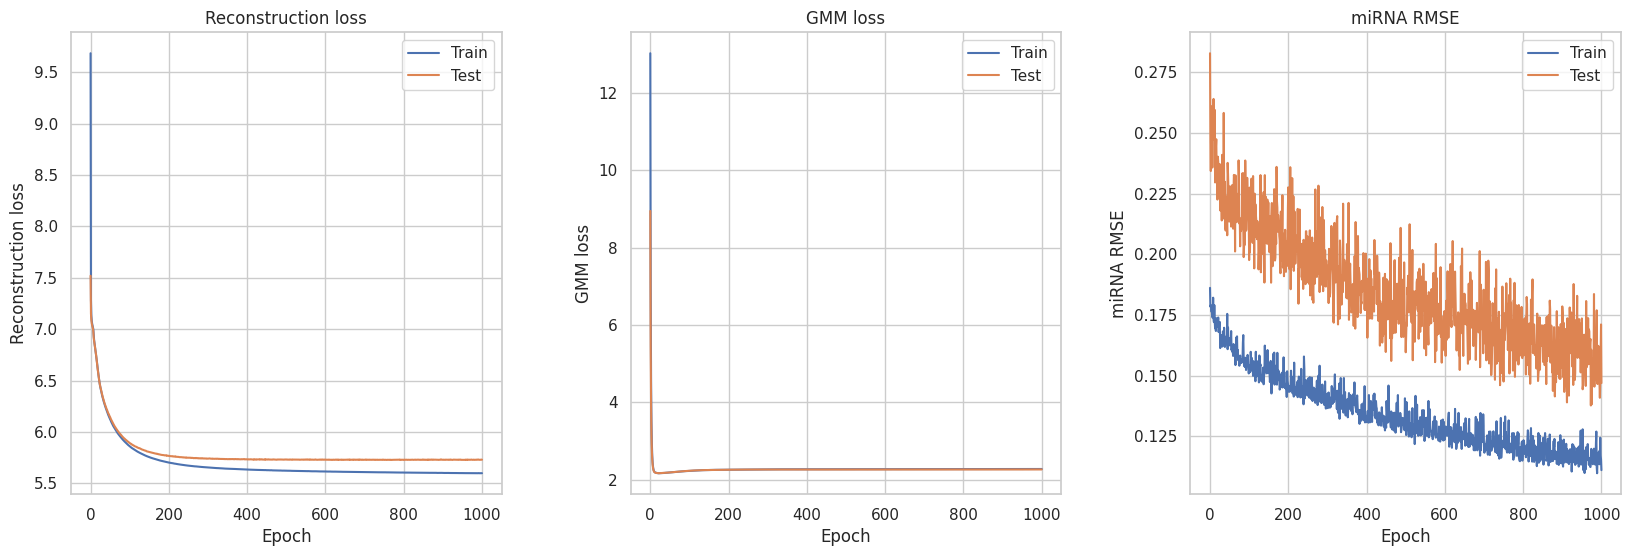

In [20]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a figure to hold the subplots
plt.figure(figsize=(20, 6))
plt.subplots_adjust(wspace=0.3)

# First subplot for Reconstruction loss
plt.subplot(1, 3, 1)
sns.lineplot(x="epoch", y="train_recon", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_recon", data=loss_tab, label="Test")
plt.title("Reconstruction loss")
plt.xlabel("Epoch")
plt.ylabel("Reconstruction loss")

# Second subplot for GMM loss
plt.subplot(1, 3, 2)
sns.lineplot(x="epoch", y="train_gmm", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_gmm", data=loss_tab, label="Test")
plt.title("GMM loss")
plt.xlabel("Epoch")
plt.ylabel("GMM loss")

# Third subplot for RMSE
plt.subplot(1, 3, 3)
sns.lineplot(x="epoch", y="train_rmse", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_rmse", data=loss_tab, label="Test")
plt.title("miRNA RMSE")
plt.xlabel("Epoch")
plt.ylabel("miRNA RMSE")

# Display the plots
plt.show()

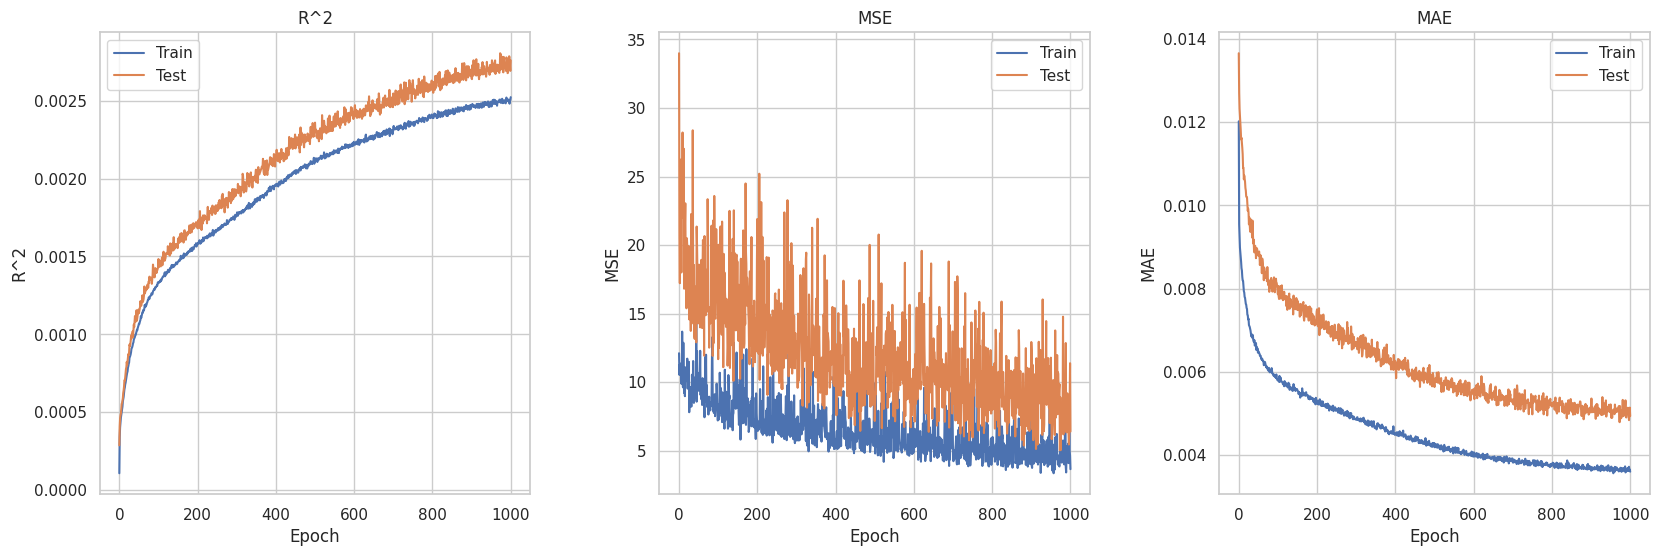

In [21]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a figure to hold the subplots
plt.figure(figsize=(20, 6))
plt.subplots_adjust(wspace=0.3)

# First subplot for Reconstruction loss
plt.subplot(1, 3, 1)
sns.lineplot(x="epoch", y="train_r2", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_r2", data=loss_tab, label="Test")
plt.title("R^2")
plt.xlabel("Epoch")
plt.ylabel("R^2")

# Second subplot for GMM loss
plt.subplot(1, 3, 2)
sns.lineplot(x="epoch", y="train_mse", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_mse", data=loss_tab, label="Test")
plt.title("MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")

# Third subplot for RMSE
plt.subplot(1, 3, 3)
sns.lineplot(x="epoch", y="train_mae", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_mae", data=loss_tab, label="Test")
plt.title("MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")

# Display the plots
plt.show()